In [1]:
import pickle
import pandas as pd
import numpy as np
from spiker import *
import matplotlib.pyplot as plt
from rnn import rnn

In [2]:
# https://www.mathworks.com/help/ident/ref/goodnessoffit.html
def goodness_of_fit(ann_states, snn_states):
    nmse_layers = []
    epsilon = 1e-14
    layers = range(len(ann_states))
    transient = 10000
    for idx in layers: # layer idx
        dims = ann_states[idx].shape[0]
        nmse = []
        for jdx in range(dims):
            ref = ann_states[idx][jdx,transient:]
            y = snn_states[idx][jdx,transient:]
            diff = ref - y
            num = np.sum(diff*diff)
            ref_ch_mean = np.mean(ref)
            ref_diff = ref - ref_ch_mean #+ epsilon
            den = np.sum(ref_diff*ref_diff)
            if (den < epsilon) | (num < epsilon):
                if num < den:
                    nmse += [1]
            else:
                nmse += [1 - (num/den)]
        nmse_layer = np.mean(nmse)
        print(f'MSE in layer {idx} is {nmse_layer:.3f}')
        nmse_layers += [nmse_layer]
    return nmse_layers
# goodness_of_fit(ann_states, snn_states)

In [3]:
def plot_activations(net, ann_states, rnn_states, label=''):
    plt.rcParams['lines.linewidth'] = 1.2
    import matplotlib.patches as mpatches
    # Plotting and visualization
    print('Pole frequency = {0:.3f} Hz'.format(1/net.tau))
    goodness = goodness_of_fit(ann_states, snn_states)
    for idx in range(len(ann_states)): # layer idx
        dims = ann_states[idx].shape[0]
        if dims >= 3:
            cols = 3
        else:
            cols=dims
        rows = int(np.ceil(dims/cols))
        fig, axs = plt.subplots(rows,cols)
        for jdx in range(ann_states[idx].shape[0]): # dim idx
            ax = plt.subplot(rows,cols,jdx+1)
            plt.plot(tsteps, ann_states[idx][jdx,:], color='r', linestyle='-.', label=f'ANN - Layer {idx}')
            plt.plot(tsteps, snn_states[idx][jdx,:], color='g', alpha=0.7, label=f'SNN - Layer {idx}')
            plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            
        label_ext = r' $c_{v_p} = $'+f'{mismatch}.'+f' NMSE = {goodness[idx]:.3f}.'
            
        if idx == 0:
            fig.suptitle(f'Input dense layer.'+label_ext, fontsize=12)
        elif idx == len(ann_states)-1:
            fig.suptitle(f'Output dense layer.'+label_ext, fontsize=12)
        elif idx%2 == 1:
            fig.suptitle(f'Recurrent layer {int(np.floor((idx+1)/2))}.'+label_ext, fontsize=12)
        else:
            fig.suptitle(f'Dense layer {int(np.floor((idx)/2))}.'+label_ext, fontsize=12)
        patch1 = mpatches.Patch(color='g', label='ANN output')
        patch2 = mpatches.Patch(color='r', label='SNN output')
        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        fig.legend(handles=[patch1, patch2], loc='lower center', fancybox=True, shadow=True, fontsize=12, ncol=2)
        plt.savefig(f'./img/ANN-RNN-Layer-{idx}-{label}.png', dpi=300)
    t = 0
    for N in net.neurons:
        t += np.sum(N.spike_count)
    print('Average spike rate = {0:.3f} KHz'. format(1e-3*t/(tsteps[-1]*op_dim+res_dim+ip_dim)))

Sequence length is 200000


(2, 200000)

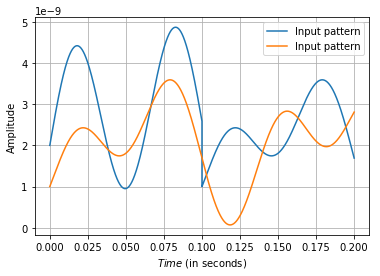

In [4]:
# Generate simulation data
def gen_data(nblocks,f1,f2, tstart=0, tstop=0.0001, Ts=1e-6,amp=1e-9):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    #np.random.seed(1)
    tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
    time = tseries.time
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+1*np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 1*np.sin(2*np.pi*timeblock*f2)+2*np.sin(2*np.pi*timeblock*f1)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op, time
# Some input
ip1,_,tsteps = gen_data(nblocks=2, f1=4, f2=15, tstop=0.2)
ip2,_,tsteps = gen_data(nblocks=1, f1=4, f2=15, tstop=0.2)

inp1 = Tseries(ip1, tsteps)
inp2 = Tseries(ip2, tsteps)
inp1.plot(label = "Input pattern")
inp2.plot(label = "Input pattern")
ip = np.stack((ip1,ip2))
print('Sequence length is {}'.format(ip.shape[1]))
ip.shape# = (1,ip.shape[0])

In [5]:
def run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams):
    net = rnn(nrlayers, ip_dim, res_dim, op_dim, nparams=nparams)
    ann_states = net.rnn_forward(ip, mode='ann')
    snn_states = net.rnn_forward(ip, mode='snn')
    return ann_states, snn_states, net

In [13]:
ip_dim = ip.shape[0]
op_dim = 3
res_dim = 500
nrlayers = 4
seq_len = ip.shape[1]
nparams = {}
nmse_avgs = {}
nmse_stds = {}
nruns = 100

In [14]:
# Test case to study effect of mismatch
mismatch_list = [0, 0.2, 1, 1.5, 2]
# mismatch_list = [0, 2]
for mismatch in mismatch_list:
    print('='*89)
    print(f'Running {nruns} tests with mismatch std = {mismatch}')
    nmse_runs = []
    for _ in range(nruns):
        print(f'Test #{_+1}/{nruns}'+'-'*10)
        nparams['mismatch'] = mismatch
        ann_states, snn_states,_ = run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams)
        nmse_runs += [goodness_of_fit(ann_states, snn_states)]
    nmse_runs = np.array(nmse_runs)
    nmse_avgs[r'$\sigma$ '+f' = {mismatch}'] = np.mean(nmse_runs, axis=0)
    nmse_stds[r'$\sigma$ '+f' = {mismatch}']  = np.std(nmse_runs, axis=0)
#     plt.semilogy(range(len(ann_states)), nmse_avgs[mismatch], label = f'Mismatch std = {mismatch}')
nmse_avgs = pd.DataFrame.from_dict(nmse_avgs)
nmse_stds = pd.DataFrame.from_dict(nmse_stds) 
results = (nmse_avgs, nmse_stds)
with open(f'./img/mapping_mismatch_r{res_dim}.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running 100 tests with mismatch std = 0
Test #1/100----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.980
MSE in layer 2 is 0.936
MSE in layer 3 is 0.875
MSE in layer 4 is 0.887
MSE in layer 5 is 0.782
MSE in layer 6 is 0.829
MSE in layer 7 is 0.483
MSE in layer 8 is 0.638
Test #2/100----------


MemoryError: 

In [ ]:
with open(f'./img/mapping_mismatch_r{res_dim}.pickle', 'rb') as handle:
    nmse_avgs, nmse_stds = pickle.load(handle)

In [ ]:
label = []
for idx in range(2*nrlayers+1):
    if idx == 0:
        label += [f'Input dense layer']
    elif idx == len(ann_states)-1:
        label += [f'Output dense layer']
    elif idx%2 == 1:
        label += [f'Recurrent layer {int(np.floor((idx+1)/2))}']
    else:
        label += [f'Dense layer {int(np.floor((idx)/2))}']

def dump_df(df, label):
    layer_names = df['Layer'].values
    indices = df.index.values.tolist()
    df.T.columns = layer_names
    df = df.set_index('Layer')
    with open(f'./img/mismatch_sims_{label}.tex', 'w') as tf:
         tf.write(df.to_latex(escape=False, float_format=lambda x: '%.1f' % x))
    return df

In [ ]:
nmse_stds['Layer'] = label
nmse_avgs['Layer'] = label
nmse_avgs.set_index('Layer')
nmse_stds.set_index('Layer')
avg_df = dump_df(nmse_avgs, "avg")
std_df = dump_df(nmse_stds, "std")
merged_df = pd.concat([avg_df.T, std_df.T], keys=['Mean', 'Std']).T
merged_df ['Layer'] = label
merged_df = dump_df(merged_df, f"{res_dim}")
merged_df

Pole frequency = 676.930 Hz
MSE in layer 0 is 1.000
MSE in layer 1 is 0.995
MSE in layer 2 is 0.986
MSE in layer 3 is 0.912
MSE in layer 4 is 0.892
MSE in layer 5 is 0.874
MSE in layer 6 is 0.886
MSE in layer 7 is 0.893
MSE in layer 8 is 0.864


C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Average spike rate = 155.929 KHz


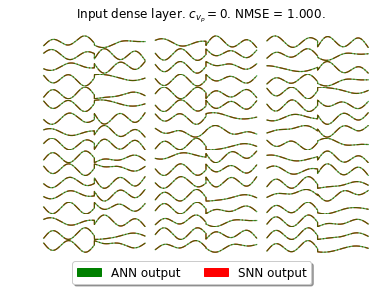

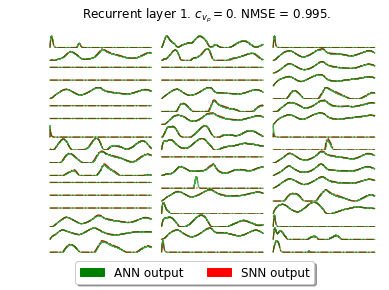

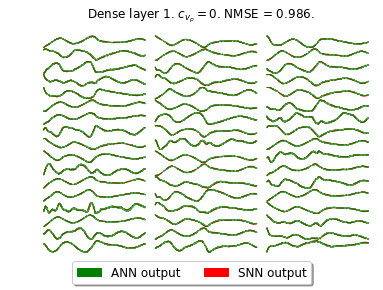

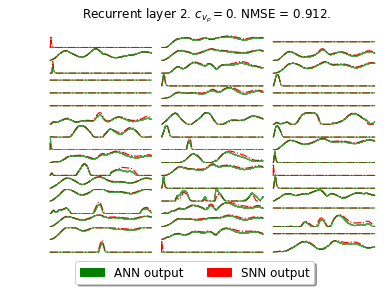

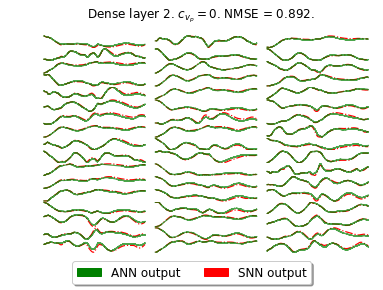

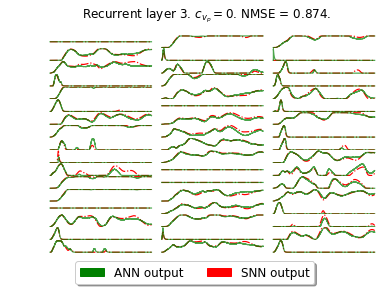

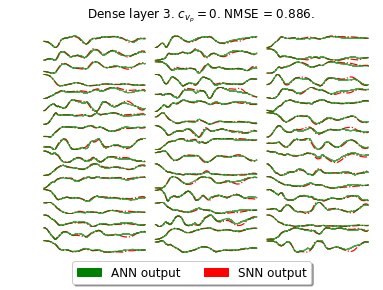

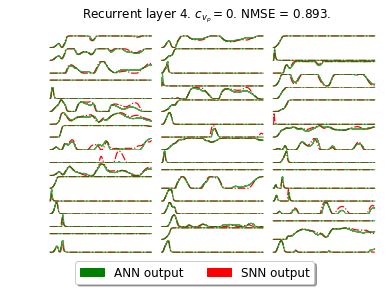

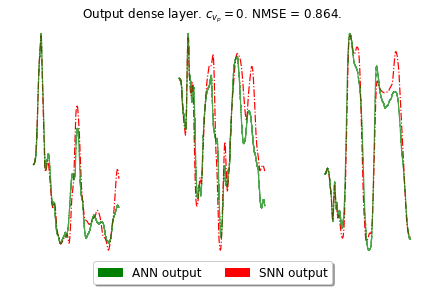

In [11]:
# Test case for plotting dynamics
mismatch = 0
nparams['mismatch'] = mismatch
ann_states, snn_states, net = run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams)
plot_activations(net, ann_states, snn_states, label=f'mismatch std={mismatch}')

Pole frequency = 676.930 Hz
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 1.000
MSE in layer 3 is 1.000
MSE in layer 4 is 1.000
MSE in layer 5 is 0.988
MSE in layer 6 is 0.983
MSE in layer 7 is -3.168
MSE in layer 8 is -0.271
Average spike rate = 64.261 KHz


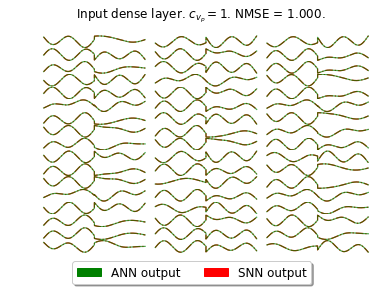

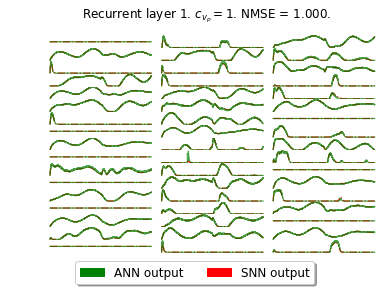

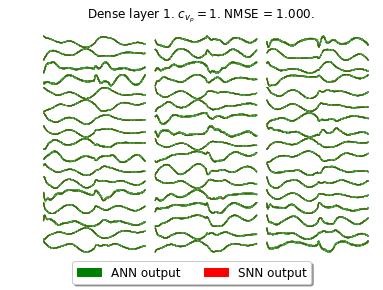

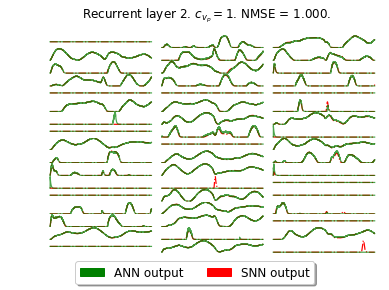

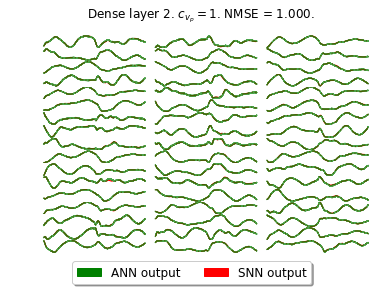

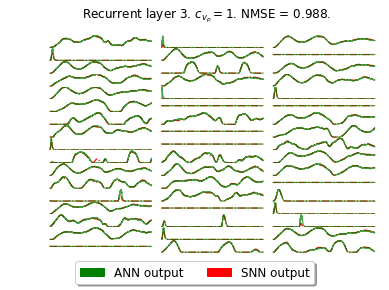

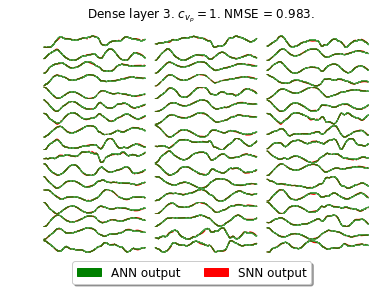

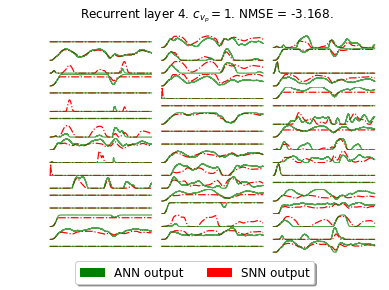

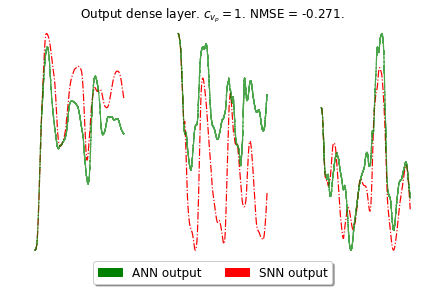

In [12]:
# Test case for plotting dynamics
mismatch = 1
nparams['mismatch'] = mismatch
ann_states, snn_states, net = run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams)
plot_activations(net, ann_states, snn_states, label=f'mismatch std={mismatch}')